In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#check test image
img = cv2.imread('./testData/Anupam.jpg')
img.shape

(720, 1280, 3)

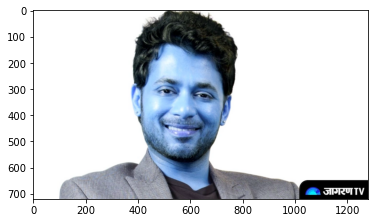

In [3]:
plt.imshow(img)

In [4]:
#change it to gray image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(720, 1280)

In [5]:
gray

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

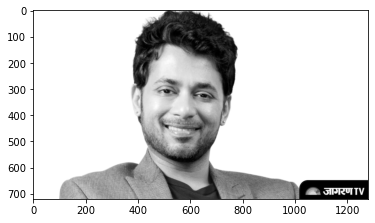

In [6]:
plt.imshow(gray, cmap='gray')

In [7]:
#detect Face and eyes
faceCascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eyeCascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')
faces = faceCascade.detectMultiScale(gray, 1.3,5)
faces

array([[379, 148, 406, 406]], dtype=int32)

In [8]:
#x axis, y axis, width, height
(x,y,w,h) = faces[0]
x,y,w,h

(379, 148, 406, 406)

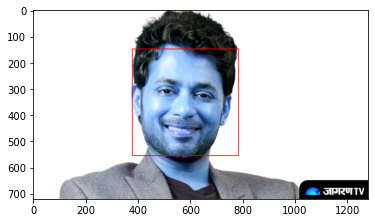

In [9]:
#Draw rectange around the face
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

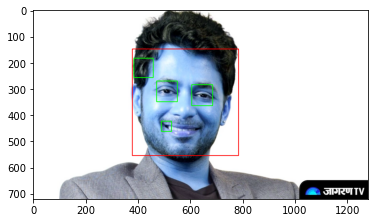

In [10]:
#draw rectange for face and detect eyes and hilight
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h,x:x+w]
    roi_color = face_img[y:y+h,x:x+w]
    eyes = eyeCascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

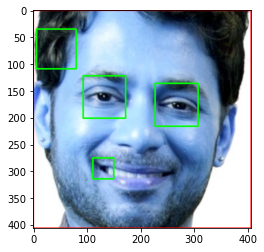

In [11]:
#show the select area
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [12]:
#now we will crop all of this and store in other so that we ca train our model
#write function for this
def get_cropped_image_if_pair_of_eyes_exist(image_path):
#     print(image_path)
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h,x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eyeCascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

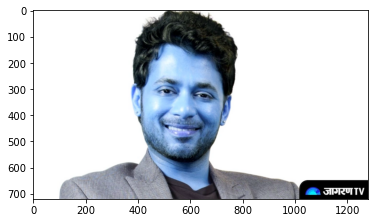

In [13]:
#lets test this
origial_image = cv2.imread('./testData/Anupam.jpg')
plt.imshow(origial_image)

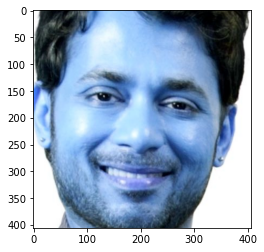

In [14]:
cropped_image = get_cropped_image_if_pair_of_eyes_exist('./testData/Anupam.jpg')
plt.imshow(cropped_image)

In [15]:
#Now we will create a folder and save all cropped image in that
path_to_data = "./dataset"
path_to_cr_data = "./dataset/cropped/"

In [18]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [19]:
img_dirs

['./dataset/Anupam_Mittal',
 './dataset/Ashneer_Grover',
 './dataset/Namita_Thapar',
 './dataset/Peyush_Bansal',
 './dataset/Aman_Gupta',
 './dataset/Vineeta_Singh']

In [20]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [21]:
cropped_image_dirs = []
shark_file_name_dict = {}
for img_dir in img_dirs:
    count = 1
    #get sharkname
    shark_name = img_dir.split('/')[-1]
    shark_file_name_dict[shark_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_pair_of_eyes_exist(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + shark_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
            cropped_file_name = shark_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name

            cv2.imwrite(cropped_file_path,roi_color)
            shark_file_name_dict[shark_name].append(cropped_file_path)
            count += 1

In [22]:
#Apply wavelet tranformation
import pywt

def w2d(img, mode="haar",level=1):
    imArray = img
    #datatyoe coversion
    imArray = cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    #to float
    imArray = np.float32(imArray)
    imArray /= 255
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    
    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

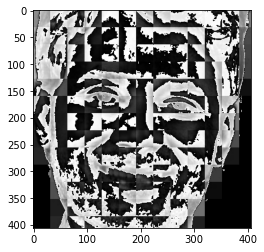

In [23]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

In [24]:
#generate number for each shark
class_dict = {}
count = 0
for shark_name in shark_file_name_dict.keys():
    class_dict[shark_name] = count
    count += 1
class_dict

{'Anupam_Mittal': 0,
 'Ashneer_Grover': 1,
 'Namita_Thapar': 2,
 'Peyush_Bansal': 3,
 'Aman_Gupta': 4,
 'Vineeta_Singh': 5}

In [25]:
#place horizontal
X = []
y = []
for shark_name, training_files in shark_file_name_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img,(32,32))
        img_har = w2d(img,'db1',5)
        scalled_har_img = cv2.resize(img_har,(32,32))
        combined_image = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_har_img.reshape(32*32,1)))
        X.append(combined_image)
        y.append(class_dict[shark_name])

In [26]:
#Total Image
len(X)

467

In [27]:
#Convert X to float, reshape, to avoid sklearn warning
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(467, 4096)

## Maching Learning Models 
#### Done with Data Cleaning

In [28]:
#Lets start with SVM with ebf kernal tuned with heuristic fine tuning
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
pipe = Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel='rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.717948717948718

In [32]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.76      0.78        25
           1       0.55      0.71      0.62        17
           2       0.78      0.74      0.76        19
           3       0.74      1.00      0.85        14
           4       0.75      0.52      0.62        23
           5       0.72      0.68      0.70        19

    accuracy                           0.72       117
   macro avg       0.72      0.73      0.72       117
weighted avg       0.73      0.72      0.71       117



### GRID SEARCH CV

In [34]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [35]:
model_params = {
    'svm' : {
        'model' :svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C' : [1,10,100,1000],
            'svc__kernel' : ['rbf','linear']
        }
    },
    'random_forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [37]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'],cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score':clf.best_score_,
        'best_params':clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.680000,"{'svc__C': 1, 'svc__kernel': 'rbf'}"
1,random_forest,0.508571,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.691429,{'logisticregression__C': 5}


In [38]:
best_estimators['svm'].score(X_test,y_test)

0.7008547008547008

In [39]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7264957264957265

In [40]:
best_clf = best_estimators['svm']

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[17,  3,  2,  1,  1,  1],
       [ 0, 11,  0,  0,  3,  3],
       [ 1,  1, 15,  1,  1,  0],
       [ 1,  0,  0, 13,  0,  0],
       [ 4,  5,  0,  0, 13,  1],
       [ 1,  1,  1,  1,  2, 13]])

Text(69.0, 0.5, 'Truth')

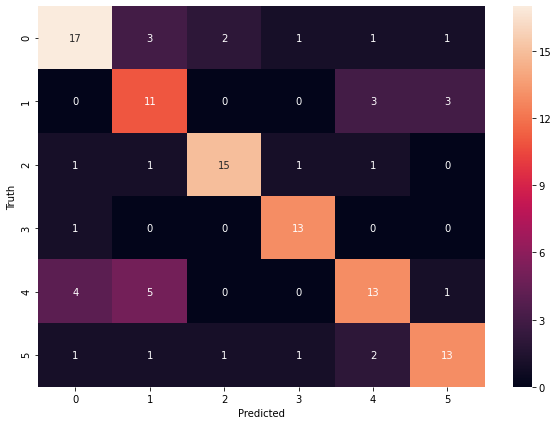

In [44]:
#to plot confusion matirx using seaborn libary
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [45]:
class_dict

{'Anupam_Mittal': 0,
 'Ashneer_Grover': 1,
 'Namita_Thapar': 2,
 'Peyush_Bansal': 3,
 'Aman_Gupta': 4,
 'Vineeta_Singh': 5}

In [46]:
#save model
!pip install joblib
import joblib
joblib.dump(best_clf,'saved_model.pkl')

['saved_model.pkl']

In [47]:
#Save Dict
import json
with open("class_dict.json","w") as f:
    f.write(json.dumps(class_dict))